# LPSpline Demo

This notebook demonstrates how to use the `lpspline` package to build and optimize linear spline models using the additive API.

In [19]:
import numpy as np
import polars as pl
try:
    import matplotlib.pyplot as plt
except ImportError:
    import os
    os.system('pip install matplotlib')
    import matplotlib.pyplot as plt
from lpspline import l, pwl, bs, cs, f
from lpspline.viz import plot_components
from lpspline.constraints import Monotonic, Convex, Concave

# Set seed for reproducibility
np.random.seed(42)

## 1. Generate Synthetic Data

We create a dataset with various non-linear relationships.

In [20]:
n = 1000
x_linear = np.linspace(0, 10, n)
x_pwl = np.linspace(0, 10, n)
x_bs = np.linspace(0, 10, n)
x_cyc = np.linspace(0, 2*np.pi, n)
x_factor = np.random.randint(0, 3, n)

# True functions
y_linear = -1 * x_linear
y_pwl = np.where(x_pwl < 5, 0, x_pwl - 5) # Hinge at 5
y_bs = np.sin(x_bs) # Sine wave
y_cyc = np.cos(x_cyc) # Cosine wave
y_factor = np.array([0, 2, -1])[x_factor] # Categorical effects

# Combined target with noise
y = (
    y_linear + 
    y_pwl + 
    y_bs + 
    y_cyc + 
    y_factor + 
    np.random.normal(0, 0.2, n)
)

df = pl.DataFrame({
    "xl": x_linear,
    "xpwl": x_pwl,
    "xbs": x_bs,
    "xcyc": x_cyc,
    "xfactor": x_factor,
    "target": y
})

print(df.head())

shape: (5, 6)
┌─────────┬─────────┬─────────┬──────────┬─────────┬──────────┐
│ xl      ┆ xpwl    ┆ xbs     ┆ xcyc     ┆ xfactor ┆ target   │
│ ---     ┆ ---     ┆ ---     ┆ ---      ┆ ---     ┆ ---      │
│ f64     ┆ f64     ┆ f64     ┆ f64      ┆ i64     ┆ f64      │
╞═════════╪═════════╪═════════╪══════════╪═════════╪══════════╡
│ 0.0     ┆ 0.0     ┆ 0.0     ┆ 0.0      ┆ 2       ┆ 0.009704 │
│ 0.01001 ┆ 0.01001 ┆ 0.01001 ┆ 0.006289 ┆ 0       ┆ 0.83379  │
│ 0.02002 ┆ 0.02002 ┆ 0.02002 ┆ 0.012579 ┆ 2       ┆ 0.054011 │
│ 0.03003 ┆ 0.03003 ┆ 0.03003 ┆ 0.018868 ┆ 2       ┆ -0.01023 │
│ 0.04004 ┆ 0.04004 ┆ 0.04004 ┆ 0.025158 ┆ 0       ┆ 0.951883 │
└─────────┴─────────┴─────────┴──────────┴─────────┴──────────┘


## 2. Define API and Model

We define the components and add them together to create the model.

In [21]:
# Create model using additive syntax
model = (
    +l(term='xl', bias=True)
    + pwl(term='xpwl', knots=[5.])
    + bs(term="xbs", knots=np.linspace(-5, 15, 10), degree=3)
    + cs(term="xcyc", period=2*np.pi, order=2)
    + f(term="xfactor", n_classes=3)
)

## 3. Fit the Model

We use the `fit` method on the combined model.

In [22]:
model.fit(df, df["target"])

print("Model fitted successfully.")


✨ Model Summary ✨
Problem Status: ✅ optimal
--------------------------------------------------------------------------------
Spline Type               | Term            | Params   | Constraints                   
--------------------------------------------------------------------------------
🟢 Linear                 | xl              | 2        | None                          
🟢 PiecewiseLinear        | xpwl            | 3        | None                          
🟢 BSpline                | xbs             | 6        | None                          
🟢 CyclicSpline           | xcyc            | 5        | None                          
🟢 Factor                 | xfactor         | 3        | None                          
--------------------------------------------------------------------------------
📊 Total Parameters                         | 19       |

Model fitted successfully.


## 4. Predict and Evaluate

We generate predictions and visualize the fit.

Mean Squared Error: 0.0385


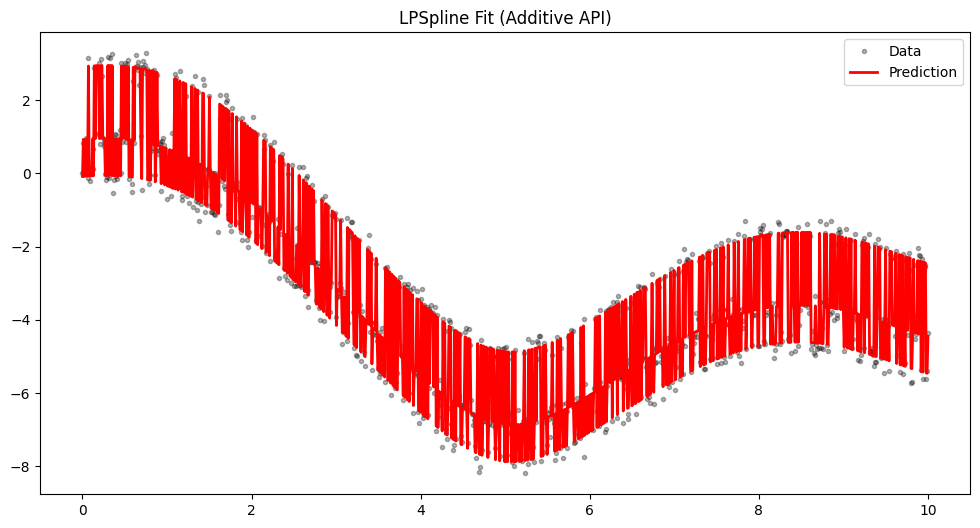

In [23]:
predictions = model.predict(df)
mse = np.mean((predictions - df["target"].to_numpy())**2)
print(f"Mean Squared Error: {mse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df["xl"], df["target"], 'k.', alpha=0.3, label='Data')
plt.plot(df["xl"], predictions, 'r-', linewidth=2, label='Prediction')
plt.legend()
plt.title("LPSpline Fit (Additive API)")
plt.show()

## 5. Visualize Spline Components

We can also visualize the individual effect of each spline component.

(<Figure size 1500x800 with 5 Axes>,
 array([<Axes: xlabel='xl'>, <Axes: xlabel='xpwl'>, <Axes: xlabel='xbs'>,
        <Axes: xlabel='xcyc'>, <Axes: xlabel='xfactor'>, <Axes: >],
       dtype=object))

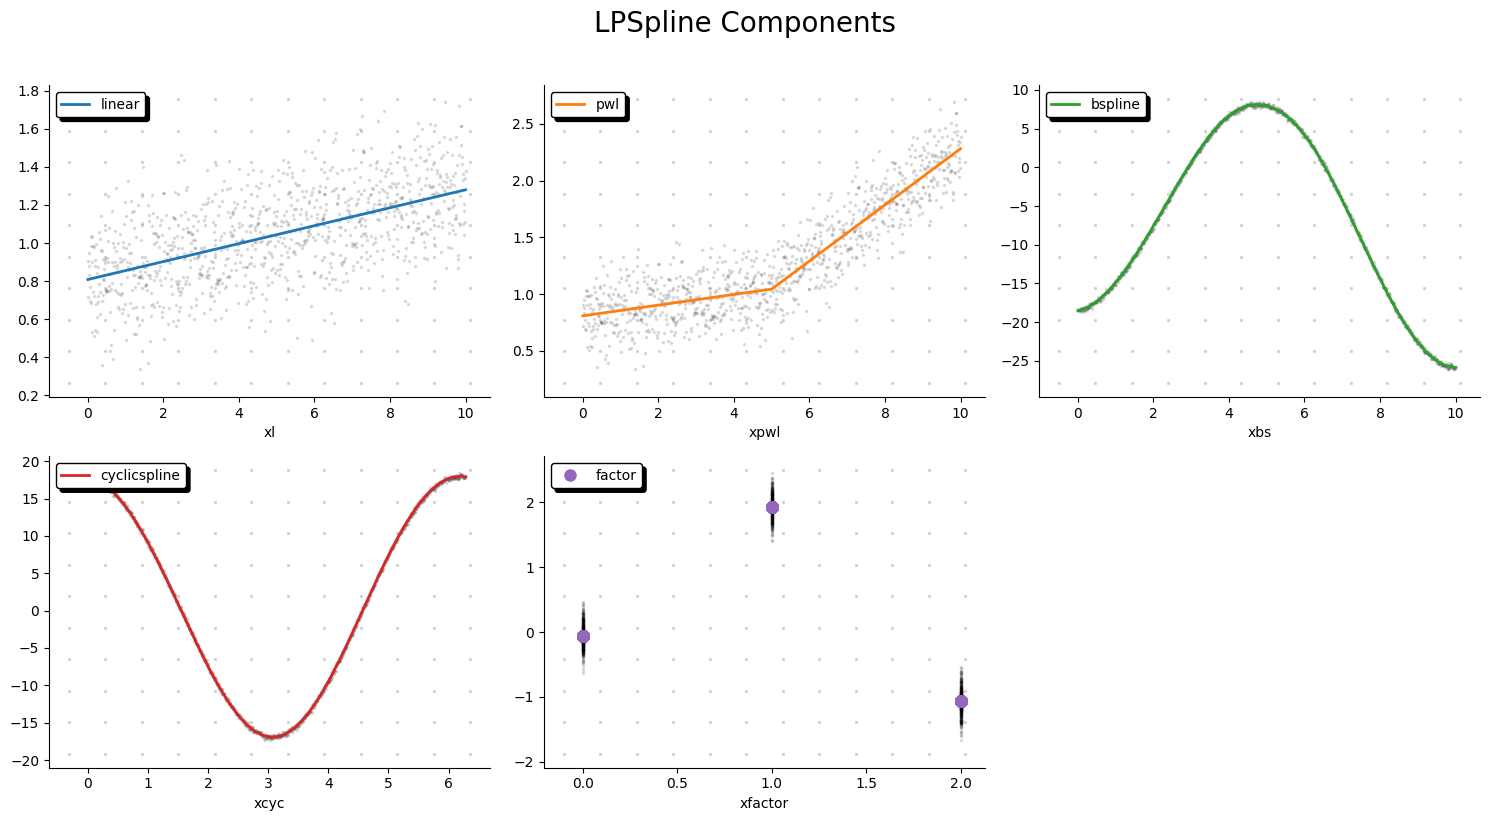

In [24]:
plot_components(model=model, X=df, ncols=3, y=df['target'])